# question/answering - using pretrained models

In [1]:
from transformers import BertTokenizerFast, BertForQuestionAnswering, pipeline, \
                         DataCollatorWithPadding, TrainingArguments, Trainer, \
                         AutoModelForQuestionAnswering, AutoTokenizer
from datasets import Dataset
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
import requests

In [2]:
# From Huggingface: https://huggingface.co/bert-large-uncased-whole-word-masking-finetuned-squad

squad_pipe = pipeline("question-answering", "bert-large-uncased-whole-word-masking-finetuned-squad")

In [3]:
squad_pipe("Where is Sinan living these days?", "Sinan lives in California but Matt lives in Boston.")

{'score': 0.9924460053443909, 'start': 15, 'end': 25, 'answer': 'California'}

In [4]:
princeton = """In 1675, a Quaker missionary from England, encouraged by New Jersey proprietors John Lord 
              "Berkeley and Sir George Carteret, arrived to establish a settlement in this area near the 
              "Delaware River, which was inhabited by the Lenni-Lenape Indians. The Keith survey of 1685 
              "established the western boundary of Middlesex and Somerset Counties and later, the Township 
              "of Princeton. Today Keith's Line is recognized as Province Line Road. With the laying of the 
              "cornerstone for Nassau Hall in 1754, Princeton began its development as a location for 
              "quality education. Nassau Hall was named for William III, Prince of Orange-Nassau. This simple stone 
              "edifice was one of the largest public buildings in the colonies and became a model for many other 
              "structures in New Jersey and Pennsylvania."""

In [5]:
squad_pipe("What survey led to the founding of Princeton?", princeton)

{'score': 0.3114528954029083,
 'start': 277,
 'end': 293,
 'answer': 'The Keith survey'}

In [6]:
swimming =  """Motor systems are areas of the brain that are directly or indirectly involved in producing
              "body movements, that is, in activating muscles. Except for the muscles that control the eye, which are
              "driven by nuclei in the midbrain, all the voluntary muscles in the body are directly innervated by motor
              "neurons in the spinal cord and hindbrain. Spinal motor neurons are controlled both by neural circuits
              "intrinsic to the spinal cord, and by inputs that descend from the brain. The intrinsic spinal circuits
              "implement many reflex responses, and contain pattern generators for rhythmic movements such as walking
              "or swimming. The descending connections from the brain allow for more sophisticated control."""

In [7]:
squad_pipe("How are the movements for swimming created?", swimming)

{'score': 0.29079753160476685,
 'start': 624,
 'end': 642,
 'answer': 'pattern generators'}

In [8]:
# visualize logits
large_tokenizer = AutoTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

qa_input = large_tokenizer(  # tokenize our example
    "Where is Sinan living these days?", "Sinan lives in California but Matt lives in Boston.",
    return_tensors='pt'
)

In [9]:
large_qa_bert = AutoModelForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

output = large_qa_bert(**qa_input)  # pass the input through our QA model
output

QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-5.4601, -6.2255, -7.8363, -7.1762, -8.4660, -6.4108, -6.7524, -8.1289,
         -8.7000, -5.4599,  0.6538, -2.8565, -1.1788,  1.0216,  7.0426, -5.2244,
         -1.3684, -5.9469, -4.9360, -0.0566, -5.4591, -5.4591]],
       grad_fn=<CloneBackward0>), end_logits=tensor([[-1.0355, -5.8719, -5.9027, -7.3427, -5.7653, -6.1145, -6.2080, -5.3895,
         -5.7630, -1.0352, -4.9416, -3.3419, -4.7643, -3.9473,  7.5046, -1.7702,
         -2.6509, -5.6540, -5.9817,  1.0278, -1.0357, -1.0406]],
       grad_fn=<CloneBackward0>), hidden_states=None, attentions=None)

In [10]:
token_labels = large_tokenizer.convert_ids_to_tokens(qa_input['input_ids'].squeeze())

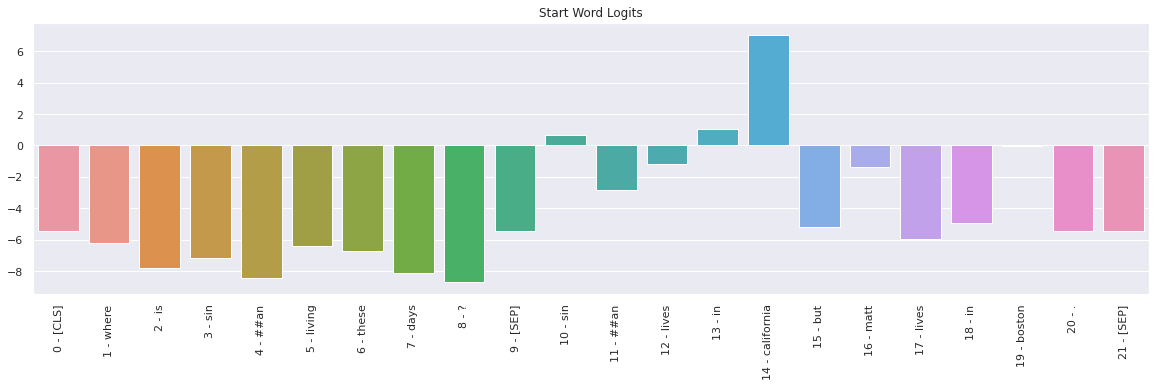

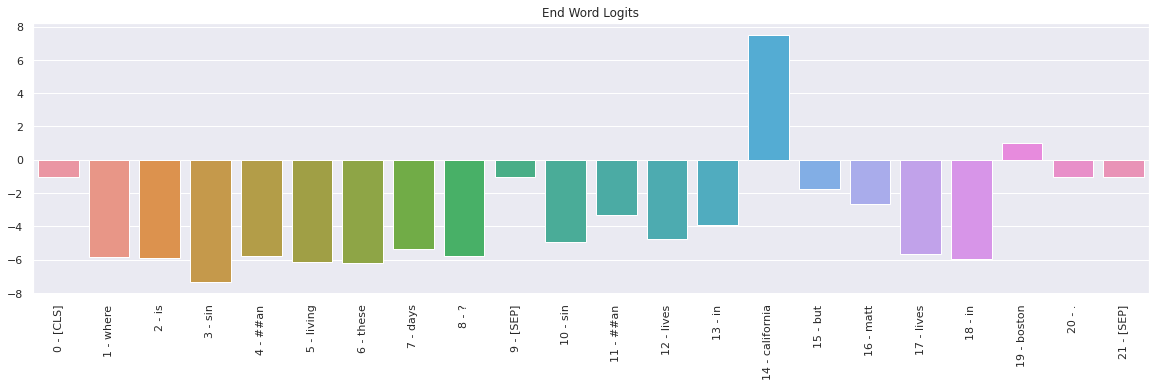

In [11]:
# Plot start and end logits for our fine-tuned model

sns.set(rc={"figure.figsize":(20, 5)}) 

# Create a barplot showing the start word score for all of the tokens.
ax = sns.barplot(x=[f'{i} - {t}' for i, t in enumerate(token_labels)], y=output.start_logits.squeeze().tolist(), ci=None)
# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
# Turn on the vertical grid to help align words to scores.
plt.title('Start Word Logits')

plt.show()

# Create a barplot showing the end word score for all of the tokens.
ax = sns.barplot(x=[f'{i} - {t}' for i, t in enumerate(token_labels)], y=output.end_logits.squeeze().tolist(), ci=None)
# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
# Turn on the vertical grid to help align words to scores.
plt.title('End Word Logits')

plt.show()